In [ ]:
import os                                     # operating system
import numpy as np                            # linear algebra
from PIL import Image                         # Python image library
import matplotlib.pyplot as plt               # making plots
%matplotlib inline
from IPython.display import display           # displaying ?

import warnings                               # ignoring unnecessary python warnings
warnings.filterwarnings('ignore')

from keras.applications import VGG16                         # pretrained CNN
from keras.callbacks import ModelCheckpoint                  # furter train the saved model
from keras import models, layers, optimizers                 # building DNN is keras
from tensorflow.keras.models import load_model               # load saved model
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:

base_dir = '/content/drive/MyDrive/Capstone/Fire_Detection_Data/'

train_dir = os.path.join(base_dir, 'train')
train_dir_fire = os.path.join(train_dir, 'Fire')
train_dir_nofire = os.path.join(train_dir, 'no-Fire')

test_dir = os.path.join(base_dir, 'test')
test_dir_fire = os.path.join(test_dir, 'Fire')
test_dir_nofire = os.path.join(test_dir, 'no-Fire')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1320 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator, epochs=2, validation_data=test_generator) # epochs=30

Epoch 1/2
42/42 [==============================] - 42s 999ms/step - loss: 0.2209 - acc: 0.9098 - val_loss: 0.2657 - val_acc: 0.8614
Epoch 2/2
42/42 [==============================] - 32s 765ms/step - loss: 0.2053 - acc: 0.9159 - val_loss: 0.1526 - val_acc: 0.9217


In [ ]:
model.save('/content/drive/MyDrive/Capstone/')

In [ ]:
# Dictionary to extract the numbers
hist_dict = history.history

# Training and validation accuracy
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs
epoches = range(1, 1 + len(training_acc))

In [ ]:
def plot_func(entity):

    '''
    This function produces plot to compare the performance
    between train set and validation set.
    entity can be loss of accuracy.
    '''

    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

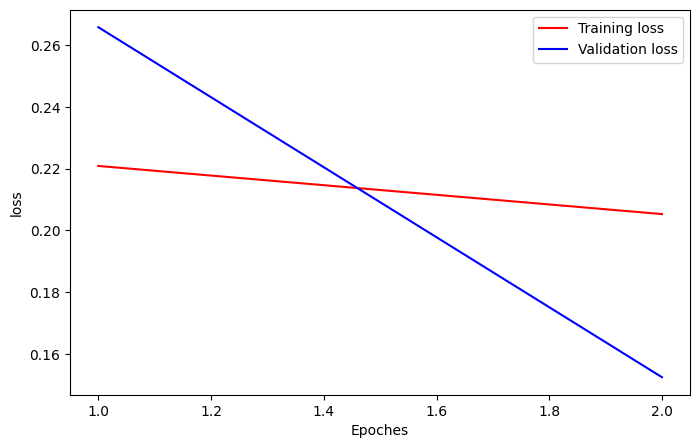

In [ ]:
plot_func('loss')

Fine-tuning the Model

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator, epochs=2,
                             validation_data=test_generator)

Epoch 1/2
42/42 [==============================] - 38s 897ms/step - loss: 14386.5000 - acc: 0.5242 - val_loss: 0.6853 - val_acc: 0.4880
Epoch 2/2
42/42 [==============================] - 34s 785ms/step - loss: 0.6923 - acc: 0.5295 - val_loss: 0.6933 - val_acc: 0.4759


In [ ]:
model.save('/content/drive/MyDrive/Capstone/')

In [ ]:
hist_dict = history.history

training_accuracy = hist_dict['acc']
validation_accuracy = hist_dict['val_acc']

training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

epoches = range(1, 1 + len(training_acc))


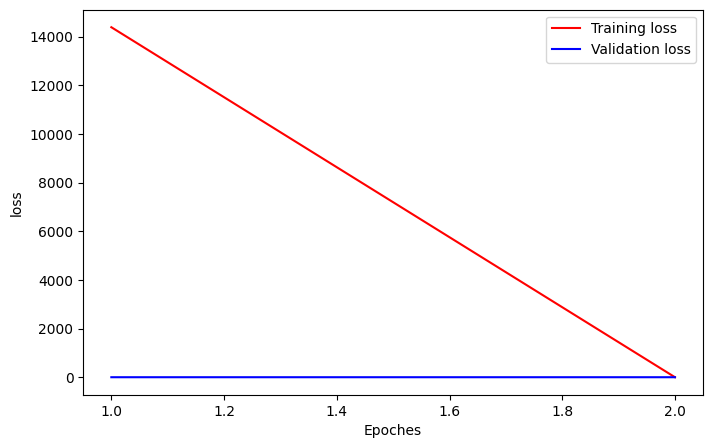

In [ ]:
plot_func('loss')


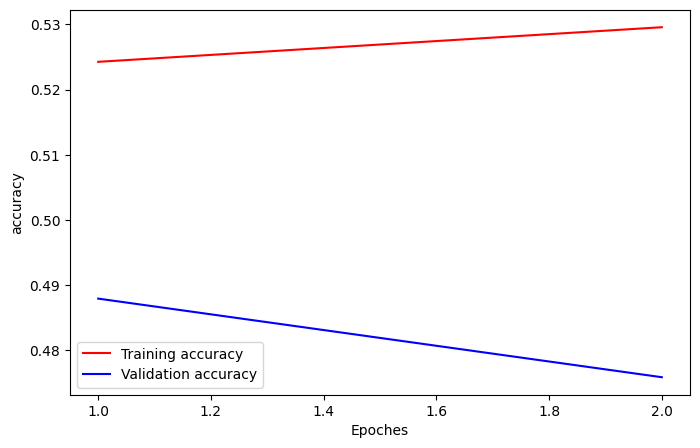

In [ ]:
plot_func('accuracy')


In [ ]:
# Loading the saved model
model = load_model('/content/drive/MyDrive/Capstone/')

In [ ]:
# taking first batch from the generator
img, label = test_generator[0]

# Predicting the images from the first batch
pred = np.round(model.predict(img)).flatten()

1/1 [==============================] - 0s 168ms/step


In [ ]:
len(img)

32

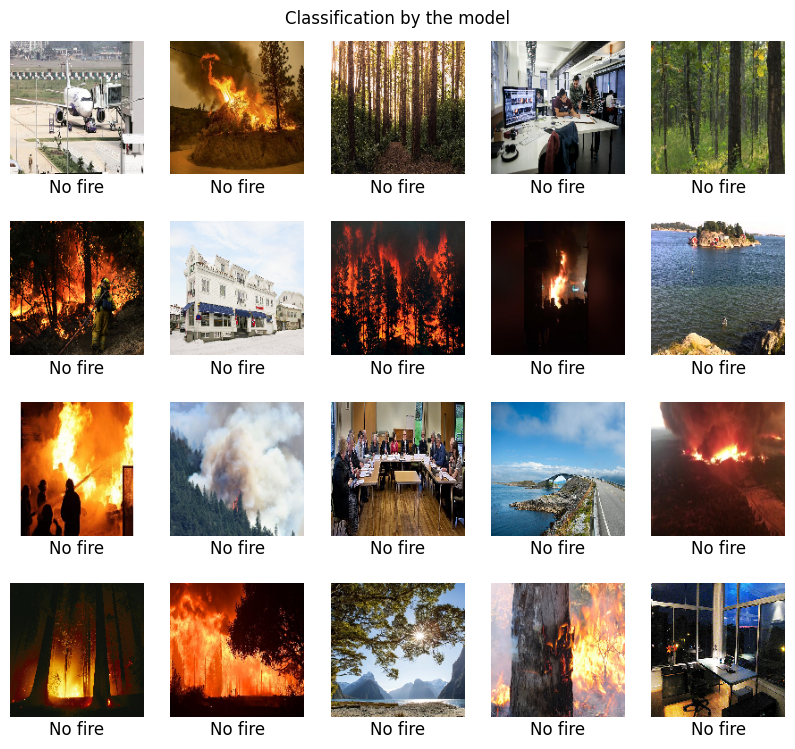

In [ ]:
# Numeric to semantic labels
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)